## 欢迎来到第一周自动驾驶课程

### 本周课程我们会详细讲解可行驶空间分割的相关知识，并且为大家系统性的介绍项目课的第一个项目

### 本周主要内容：

1. 可行驶空间问题的介绍

2. 可行驶空间项目数据集介绍, 数据预处理

3. 可行驶空间算法设计

4. 可行驶空间算法构造
     1. dataloader构造
     2. 模型构造
     3. 模型评估与测试
     4. 模型后处理与可视化
     
5. 可行驶空间模型进一步提升

6. 总结
    

## 可行驶空间问题介绍

可行驶空间分割是自动驾驶中高速路段行车的重要应用，和车道线分割一起，可以确保高速行车无碰撞空间。可行驶空间分割最终形成像素级的预测结果，可以作为轨迹预测和路径规划等下游任务的输入。

一般来说，可行驶空间根据场景划分，可分为主市区、城际道路、高速、郊区等场景；根据预测目的划分，可划分为当前车道行驶空间分割以及相邻车道行驶空间分割。可行驶空间问题受到天气、气候、一天中的不同时段以及光照的影响，其表现也会有相对应的不同，在有些不利条件下，训练难度会相应增加。


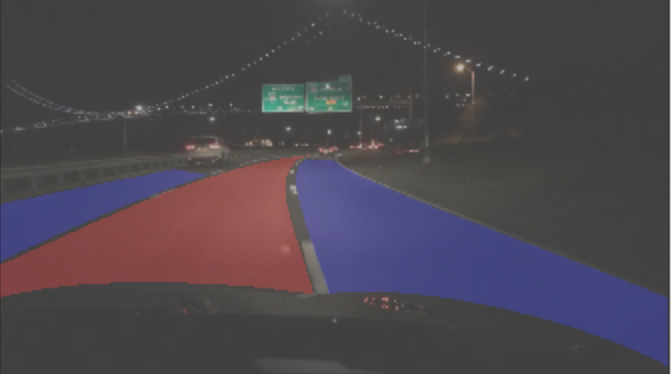

## 可行驶空间数据集介绍
这里为大家简要介绍一下这个项目的数据集。数据集是从视频截取而来的，每一帧自成一张图片。其中大家需要关心三点，图像，分割图和注释。
首先简单为大家展示一下输入图像。

In [ ]:
import os
import glob
image_pth = "/Volumes/EXTERNAL_USB/auto/freespace_dataset/images/data/val/*.jpg"
image_list = glob.glob(image_pth)

In [ ]:
image_list[0]

In [ ]:
import matplotlib.pyplot as plt
im_path = image_list[2]
img = plt.imread(im_path)
plt.imshow(img)
plt.axis('off')

In [ ]:
drivable_map = im_path.replace("images/100k", "drivable_maps/labels")
drivable_map_affix = drivable_map.split("/")[-1].split(".")[0] + "_drivable_id.png"
drivable_map = "/".join(drivable_map.split("/")[:-1] + [drivable_map_affix])
print(drivable_map)
d_map =  plt.imread(drivable_map)
plt.imshow(d_map)
plt.axis('off')

In [ ]:
color_drivable_map = im_path.replace("images/100k", "drivable_maps/color_labels")
color_drivable_map_affix = color_drivable_map.split("/")[-1].split(".")[0] + "_drivable_color.png"
color_drivable_map = "/".join(color_drivable_map.split("/")[:-1] + [color_drivable_map_affix])
print(color_drivable_map)
color_d_map =  plt.imread(color_drivable_map)
plt.imshow(color_d_map)
plt.axis('off')

In [ ]:
print(d_map.min(), d_map.max())

In [ ]:
print(color_d_map.min(),color_d_map.max())

In [ ]:
plt.imshow(img)
plt.show()

In [ ]:
plt.imshow(d_map, alpha=0.5)
plt.imshow(img, alpha=0.5)
plt.show()

In [ ]:
plt.imshow(color_d_map, alpha=0.5)
plt.imshow(img, alpha=0.5)
plt.show()

### 总结
#### 通过对输入数据（原图+分割图）的展示，我们可以观察到，数据集的数据量大，道路场景复杂，还是具有一定挑战性的。此外，
##### 1. 图像中输入尺度不均一，需要先调整到同一尺度下才能进行实验。
##### 2.对于分割图来说有两种类型， 当前行驶道路和附近可行驶空间。在这里我们不做区分，同一合并为一类道路来训练。因此会针对性的做预处理
##### 3.针对不同光照与不同道路行驶场景，我们对应性需要做相应的数据增强

### 数据预处理
#### 1. 分割图像值限定在0与1之间
#### 2. 输出分割图像与原输入图像一一对应

In [ ]:
import numpy as np
np.unique(color_d_map)
np.sum(color_d_map[:,:,2])

In [ ]:
print(np.unique(d_map))
np.sum(d_map)
d_map[d_map>0] = 1

In [ ]:
plt.imshow(d_map, alpha=0.5)
plt.imshow(img, alpha=0.5)
plt.show()

#### 通过对输入矩阵的数值的二值化，我们得到了可以学习的分割图以及对应的输入图像。下一步我们来进行图像增强

### 数据增强
####  1. 图像亮度变化
####  2. 图像对比度变化
####  3. 图像拉伸或放缩
####  4. 图像旋转
####  5. 图像标准化

In [ ]:
img.dtype

In [ ]:
plt.imshow(img)

In [ ]:
plt.imshow(img+30)

In [ ]:
im_path = image_list[10]
img = plt.imread(im_path)
plt.imshow(img)

In [ ]:
contrast = (img*0.8).astype(np.uint8)
plt.imshow(contrast)

In [ ]:
img.shape

In [ ]:
import cv2
img_l = cv2.resize(img, (800, 600))

In [ ]:
plt.imshow(img_l)
print(img_l.shape)

In [ ]:
img_u = cv2.resize(img, (1400, 1000))
plt.imshow(img_u)
print(img_u.shape)

In [ ]:
height, width = img.shape[:2]
degree = 15

matRotation=cv2.getRotationMatrix2D((width/2,height/2),degree,1)
imgRotation=cv2.warpAffine(img,matRotation,(width,height),borderValue=(255,255,255))
plt.imshow(imgRotation)

In [ ]:
mean = np.array([0.512, 0.287, 0.382])
img_norm = img - mean
img_norm = img_norm.astype(np.int8)
plt.imshow(img_norm)